In [4]:
import torch 
import yaml

In [5]:
# Carico i parametri dal file config.yaml
with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [6]:
print(config)

{'diffusion': {'T': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'training': {'batch_size': 64, 'learning_rate': 0.0001}}


In [7]:
# Estraggo i parametri da utilizzare nel forward process
T = config['diffusion']['T'] # time-steps
beta_start = config['diffusion']['beta_start'] # rumore iniziale
beta_end = config['diffusion']['beta_end'] # rumore finale

In [9]:
print(f"Parametri caricati: T={T}, beta_start={beta_start}, beta_end={beta_end}")

Parametri caricati: T=1000, beta_start=0.0001, beta_end=0.02


In [16]:
# Definizione del NoiseScheduler
class NoiseScheduler:
    def __init__(self, T, beta_start, beta_end):
        """
        Inizializza il noise scheduler per il forward process
        T: numero di time-steps
        beta_start: rumore iniziale
        beta_end: rumore finale
        """
        self.T = T # quando l'oggetto della classe viene creato, T diventa un attributo di quell'oggetto e può essere utilizzato da altri metodi della classe.
        
        # beta_t rappresenta la varianza del rumore aggiunto a ogni passo
        self.beta = torch.linspace(beta_start, beta_end, T)
        
        # alpha_t = 1 - beta_t
        # Rappresenta quanto dell'immagine originale si è mantenuta al passo t
        self.alpha = 1.0 - self.beta
        
        # Serve per utilizzare la formula chiusa e calcolare direttame te x_t da x_0
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
    
    def add_noise(self, x0, t, noise):
        """
        Implementa il forward process:
        - x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * epsilon
        x0: immagine originale (tensor di forma [barch_size, channels, height, width])
        t: timestep
        noise: rumore gaussiano
        """
        
        # Estraggo il valore di alpha_bar_t per lo specifico t
        alpha_bar_t = self.alpha_bar[t]
        
        # Afatto la forma pe ril broadcasting con x0
        alpha_bar_t = alpha_bar_t.reshape(-1,1,1,1)
        
        # Calcolo i coefficienti
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0 - alpha_bar_t)
        
        # Equazione del forward process
        noisy_image = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise
        return noisy_image
    
# Inizializzo il scheduler
scheduler = NoiseScheduler(T, beta_start, beta_end)
        

Forma del batch di immagini: torch.Size([64, 1, 28, 28])
Forma del batch di etichette: torch.Size([64])


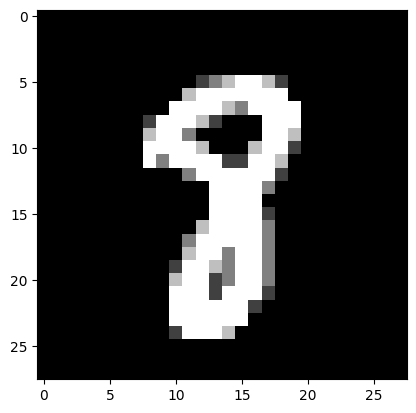

In [18]:
# test del forward process
%run ./data_loader.ipynb

In [19]:
dataloader = get_dataloader(batch_size=64)
images, _ = next(iter(dataloader))

In [20]:
noise = torch.randn_like(images)  # Rumore gaussiano
t = torch.randint(0, T, (images.shape[0],))  # Passi casuali

In [21]:
noisy_images = scheduler.add_noise(images, t, noise)

print(f"Forma delle immagini originali: {images.shape}")
print(f"Forma delle immagini rumorose: {noisy_images.shape}")

Forma delle immagini originali: torch.Size([64, 1, 28, 28])
Forma delle immagini rumorose: torch.Size([64, 1, 28, 28])


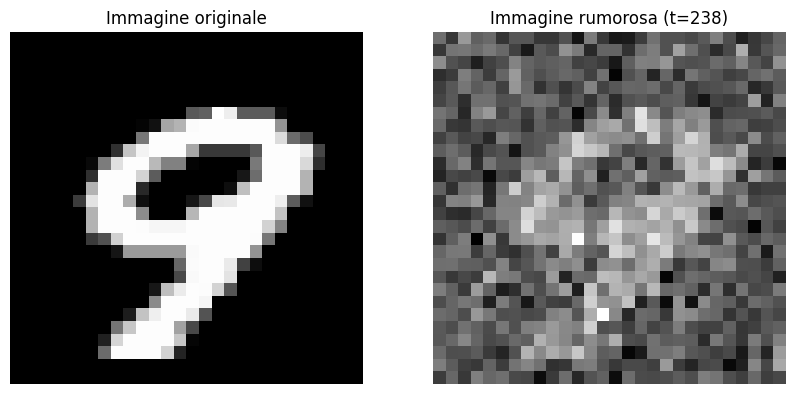

In [30]:
# Cell 4: Visualizzazione a un timestep specifico
import matplotlib.pyplot as plt

specific_t = 238 # al massimo 999

# Prendi la prima immagine del batch
image = images[0:1]  # Forma: [1, 1, 28, 28]

# Genera rumore per quell'immagine
noise = torch.randn_like(image)

# Aggiungo rumore al timestep scelto
noisy_image = scheduler.add_noise(image, torch.tensor([specific_t]), noise)

# Visualizzazione
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image[0][0], cmap='gray')
plt.title("Immagine originale")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image[0][0], cmap='gray')
plt.title(f"Immagine rumorosa (t={specific_t})")
plt.axis('off')

plt.show()